# Loading model

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(Path().resolve(),'trained_models','trained_models')
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_25 12-23-03 Deep Neural Network asian
1     2024_10_25 15-28-03 Deep Neural Network barrier_price


In [2]:
model = models[0]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")

0     2024_10_25 12-23-03 Deep Neural Network asian insample.csv
1     2024_10_25 12-23-03 Deep Neural Network asian outsample.csv
2     2024_10_25 12-23-03 Deep Neural Network asian.pkl
3     2024_10_25 12-23-03 Deep Neural Network asian.txt


In [3]:
train_data = pd.read_csv(os.path.join(model_dir,model_files[0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,model_files[1])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
model_fit = joblib.load(os.path.join(model_dir,model_files[2]))
print(model_fit)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
 

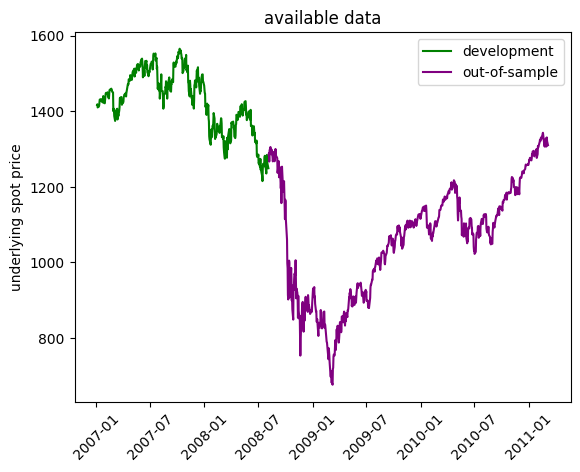

In [4]:
train_spots = train_data['spot_price']
test_spots = test_data['spot_price']
train_dates = pd.Series(train_spots.index)
test_dates = pd.Series(test_spots.index)
plt.figure()
plt.plot(train_spots,color='green',label='development')
plt.plot(test_spots,color='purple',label='out-of-sample')
plt.title('available data')
plt.ylabel('underlying spot price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [5]:
diff = test_data['outofsample_error'].copy()
def compute_RMSE(diff):
    return np.sqrt(np.mean(diff**2))
def compute_MAE(diff):
    return np.mean(np.abs(diff))
test_data['RMSE'] = diff.resample('D').apply(compute_RMSE).dropna()
test_data['MAE'] = diff.resample('D').apply(compute_MAE).dropna()
regression_data = test_data[
    [
        'spot_price',
        'theta', 
        'eta', 
        'v0',
        'RMSE', 'MAE'
    ]
].copy().drop_duplicates()

# Testing

In [6]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

### testing for the effect of the spot level on pricing accuracy

In [7]:
regression_data.dtypes

spot_price    float64
theta         float64
eta           float64
v0            float64
RMSE          float64
MAE           float64
dtype: object

### unrestricted regression

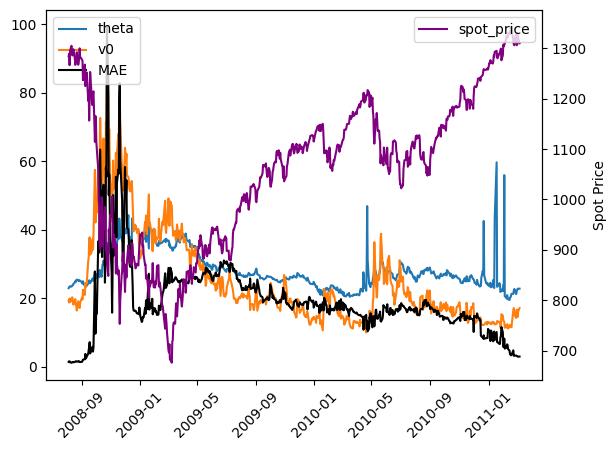

In [8]:
X = regression_data[
    [
        'spot_price',
        'theta', 
        'v0',
    ]
].copy()

X.iloc[:,1:] = np.sqrt(X.iloc[:,1:])*100

target_name = 'MAE'

y = regression_data[target_name]

fit_intercept = False

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)

for column in X.columns[1:]:
    ax1.plot(X.index, X[column], label=column)

ax1.plot(X.index, y, label=target_name, color="black")

ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(X.index, X['spot_price'], label="spot_price", color="purple")
ax2.set_ylabel("Spot Price")
ax2.legend(loc="upper right")

plt.show()

In [9]:
Ufit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Uyhat = Ufit.predict(X)
URSS = sum((Uyhat-y)**2)
print(f"features:\n{X.dtypes}\n\ntarget: {target_name}\n")
for i,c in enumerate(Ufit.coef_):
    print(f"b{i}:   {c}")
print(f"intercept: {Ufit.intercept_}")
print(f"R Squared: {Ufit.score(X,y)}")
print(f"\nURSS: {URSS}")

features:
spot_price    float64
theta         float64
v0            float64
dtype: object

target: MAE

b0:   0.00018303264648774245
b1:   0.1492238703981863
b2:   0.5837364620509482
intercept: 0.0
R Squared: 0.5210427238839829

URSS: 38999.69206750611


### restricted regression

In [10]:
X = X.iloc[:,1:]
Rfit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Ryhat = Rfit.predict(X)
RRSS = sum((Ryhat-y)**2)
print(f"features:\n{X.dtypes}\n\ntarget: {target_name}\n")
for i,c in enumerate(Rfit.coef_):
    print(f"b{i}:   {c}")
print(f"intercept: {Rfit.intercept_}")
print(f"R Squared: {Rfit.score(X,y)}")
print(f"\nRRSS: {RRSS}")

features:
theta    float64
v0       float64
dtype: object

target: MAE

b0:   0.15836501409859768
b1:   0.5808759702523631
intercept: 0.0
R Squared: 0.5210209684304874

RRSS: 39001.46353237244


### F-Test

In [11]:
m = len(Ufit.coef_)-len(Rfit.coef_)
n = len(y)
k = len(Ufit.coef_)
dfn = m
dfd = n-k-1
F = ((RRSS-URSS)/dfn)/(URSS/dfd)
alpha = 0.05
critF = stats.f.ppf(1 - alpha, dfn=dfn, dfd=dfd)
print(f"F: {F}, Critical F: {critF}")

F: 0.029433802487357254, Critical F: 3.855849170898087
